In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
import time
from sklearn.metrics import explained_variance_score

In [2]:
class AP_GRU_Lag(nn.Module):
    def __init__(self, H_no, lag, device):
        super().__init__()
        
        self.H_no = H_no
        self.device = device
        
        self.rnn = nn.GRU(lag+1, H_no, batch_first=True)
        self.linear = nn.Linear(H_no, 1)
        
    def forward(self, V):
        #V is shape (batch, 50000, lag+1)

        rnn_out, _ = self.rnn(V) #(batch,50000,H)
        rnn_out = rnn_out.reshape(-1,self.H_no)
        lin_out = self.linear(rnn_out) #(batch*50000,1)
        final = torch.sigmoid(lin_out.reshape(V.shape[0], V.shape[1]))
        
        return final



In [3]:
batch_size = 20
batch_length = 250
H_no = 40
device = torch.device("cuda")
lag = 20

epoch_no = 400
iter_no = epoch_no * 980 // batch_size

#V = np.load("/media/hdd01/sklee/CA1_clust4-60_noNA/data/vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_noDendNa_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy").reshape(-1,50001)[:,:50000]
#V = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/comb_pred/V_comb_pred_0.4ms.npy")
V = np.load("/media/hdd01/sklee/CA1_clust4-60_aSoma/na_true/V_na_true_40ms.npy").reshape(-1,batch_length)
S = np.load("/media/hdd01/sklee/CA1_clust4-60_aSoma/data/spike_train_40ms.npy").reshape(-1,batch_length)

V-= np.mean(V)

V = torch.from_numpy(V)
S = torch.from_numpy(S)

V_lag = np.zeros((V.shape[0], V.shape[1], lag)) #(lag,1000,50000)
for i in range(lag):
    #V_pad = np.zeros_like(V)
    #V_pad[:,i+1:] = V[:,:-i-1]
    #V_lag[:,:,i] = V - V_pad
    
    V_lag[:,i+1:,i] = V[:,:-i-1]

V_lag = torch.from_numpy(V_lag)
print(V_lag.shape)

torch.Size([1000, 250, 20])


In [4]:
V_train = V[:980].float()
V_test = V[980:].float().to(device)
S_train = S[:980].float()
S_test = S[980:].float().to(device)
V_lag_train = V_lag[:980].float()
V_lag_test = V_lag[980:].float().to(device)

train_idx = np.empty((epoch_no, 980))
for i in range(epoch_no):
    part_idx = np.arange(0,980,1)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.reshape(-1, batch_size)
train_idx = torch.from_numpy(train_idx).long()
print(train_idx.shape)

torch.Size([19600, 20])


In [5]:
model = AP_GRU_Lag(H_no, lag, device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0025)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

bce_criterion = nn.BCELoss(reduction="mean")

7601


In [6]:
score_list = []


#for i in tnrange(iter_no):
for i in tnrange(10000):
    s = time.time()
    model.train()
    optimizer.zero_grad()
    
    batch_idx = train_idx[i]
    batch_S = S_train[batch_idx].to(device)
    batch_V = V_train[batch_idx].to(device)
    batch_V_lag = V_lag_train[batch_idx].to(device)
    
    batch_V_in = torch.zeros(batch_size, batch_length, lag+1).to(device)
    batch_V_in[:,:,0] = batch_V
    batch_V_in[:,:,1:] = batch_V_lag
    
    S_out = model(batch_V_in)
    loss = bce_criterion(S_out, batch_S)
    
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), 10)
    optimizer.step()
    
    step_time = time.time() - s
    
    if (i%50 == 49) or (i == 0):
        model.eval()
        V_test_in = torch.zeros(batch_size, batch_length, lag+1).to(device)
        V_test_in[:,:,0] = V_test
        V_test_in[:,:,1:] = V_lag_test
        
        test_S_out = model(V_test_in)
        test_loss = bce_criterion(test_S_out, S_test).item()
        
        score_list.append(test_loss)
        print(i, test_loss)

<ipython-input-6-0033da776966>:5: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(10000):


  0%|          | 0/10000 [00:00<?, ?it/s]

0 0.6942328810691833
49 0.055686477571725845
99 0.03245372697710991
149 0.02529604360461235
199 0.02193569205701351
249 0.019091684371232986
299 0.017068080604076385
349 0.016270602121949196
399 0.014818938449025154
449 0.01513670478016138
499 0.014136248268187046
549 0.012682244181632996
599 0.012823970057070255
649 0.01314231101423502
699 0.011586952023208141
749 0.011699137277901173
799 0.01278677023947239
849 0.010834171436727047
899 0.01095903106033802
949 0.010468131862580776
999 0.01023893989622593
1049 0.011299461126327515
1099 0.009616979397833347
1149 0.00970371812582016
1199 0.009552097879350185
1249 0.010970066301524639
1299 0.009983265772461891
1349 0.009761456400156021
1399 0.008946636691689491
1449 0.009048801846802235
1499 0.00879560224711895
1549 0.00908378604799509
1599 0.008800971321761608
1649 0.008900301530957222
1699 0.00939883477985859
1749 0.008884555660188198
1799 0.009104518219828606
1849 0.011269447393715382
1899 0.009754211641848087
1949 0.008640484884381294

KeyboardInterrupt: 

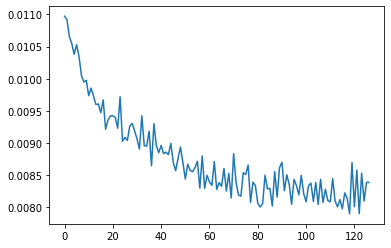

In [7]:
plt.plot(np.asarray(score_list)[20:])

tensor(0.9990, device='cuda:0', grad_fn=<MaxBackward1>)


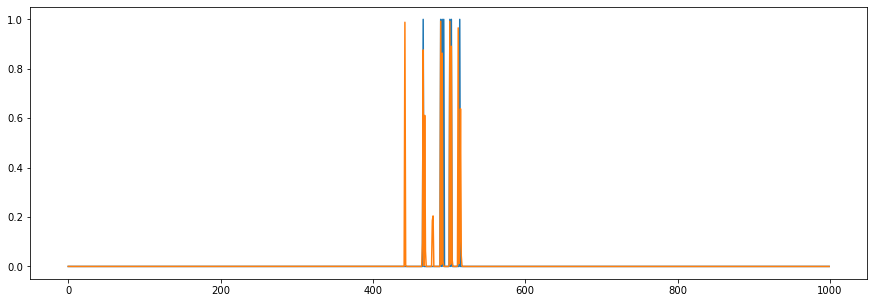

In [8]:
plt.figure(figsize = (15,5))
plt.plot(S_test[0].cpu().detach().numpy())
plt.plot(test_S_out[1].cpu().detach().numpy())
#plt.xlim(4500,5200)
#plt.ylim(-1,10)
print(torch.max(test_S_out))

In [7]:
#torch.save(model.state_dict(), "/media/hdd01/sklee/CA1_clust4-60_aSoma/na_true/gru_l20_h40_40ms.pt")
#np.save("/media/hdd01/sklee/CA1_clust4-60_aSoma/na_true/gru_l20_h40_40ms_test.npy", test_S_out.cpu().detach().numpy())